https://papers.nips.cc/paper/2019/hash/6e7d5d259be7bf56ed79029c4e621f44-Abstract.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
from IPython.display import clear_output

In [2]:
def concat_images(images, image_width, spacer_size):
    """ Concat image horizontally with spacer """
    spacer = np.ones([image_width, spacer_size, 4], dtype=np.uint8) * 255
    images_with_spacers = []

    image_size = len(images)

    for i in range(image_size):
        images_with_spacers.append(images[i])
        if i != image_size - 1:
            # Add spacer
            images_with_spacers.append(spacer)
    ret = np.hstack(images_with_spacers)
    return ret

In [3]:
def concat_images_in_rows(images, row_size, image_width, spacer_size=4):
    """ Concat images in rows """
    column_size = len(images) // row_size
    spacer_h = np.ones([spacer_size, image_width*column_size + (column_size-1)*spacer_size, 4],
                       dtype=np.uint8) * 255

    row_images_with_spacers = []

    for row in range(row_size):
        row_images = images[column_size*row:column_size*row+column_size]
        row_concated_images = concat_images(row_images, image_width, spacer_size)
        row_images_with_spacers.append(row_concated_images)

        if row != row_size-1:
            row_images_with_spacers.append(spacer_h)

    ret = np.vstack(row_images_with_spacers)
    return ret

In [4]:
def rgb(im, cmap='turbo', smooth=True):
    cmap = plt.cm.get_cmap(cmap)
    np.seterr(invalid='ignore')  # ignore divide by zero err
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    if smooth:
        im = cv2.GaussianBlur(im, (3,3), sigmaX=1, sigmaY=0)
    im = cmap(im)
    im = np.uint8(im * 255)
    return im

In [5]:
def plot_ratemaps(activations, n_plots, cmap='turbo', smooth=True, width=16):
    images = [rgb(im, cmap, smooth) for im in activations[:n_plots]]
    rm_fig = concat_images_in_rows(images, n_plots//width, activations.shape[-1])
    return rm_fig

# Single-cell dynamics
Here we perform numerical simulations to optimize the position-encoding Lagrangian (eq. 4). The place cell covariance matrix $\Sigma$ is estimated empirically from the same place cell outputs used to train the RNN. For comparison, we first optimize using a nonlinearity (tanh) which preserves the $g\to-g$ symmetry, and find predominantly heterogenous patterns. We then optimize with a nonlinearity (relu) which breaks the $g\to-g$ symmetry, and find predominantly hexagonal patterns. Notice that boundary effects can deform the regular hexagonal patterns in interesting ways.

ここでは、数値シミュレーションを行い、位置符号化ラグランジュ（式4）を最適化する。プレイスセル共分散行列$\Sigma$は、RNNの学習に用いたプレイスセル出力と同じものから経験的に推定したものである。比較のため、まず$g\to-g$対称性を保つ非線形性(tanh)を用いて最適化したところ、異質なパターンが多く見られました。次に、$g\to-g$対称性を破る非線形性(relu)を用いて最適化すると、六角形のパターンが多くなることがわかった。境界効果により、正六角形のパターンが興味深い方法で変形することに注意してください。


$$
\mathcal{E}(G, W)=\|P-\hat{P}\|_{F}^{2} \text {, where } \hat{P}=G W
$$

$P \in\mathbb{R}^{n_x\times n_P}$は場所細胞の活動である．$P_{x,i}$は$i$番目の細胞の位置インデックス$x$における活動．
$G \in\mathbb{R}^{n_x\times n_G}$は隠れ層の細胞の活動である．

$W$はread outの重み行列．正規方程式より最適な$W$は

$$
W = \underset{W}{\operatorname{argmin}} \mathcal{E}(G, W)=\left(G^{T} G\right)^{-1} G^{T} P
$$

$G\to GZ$, $W\to Z^{-1}W$としても変わらない．

ラグランジュの未定乗数法により，

$\Sigma=PP^\top$は$n_x\times n_x$の空間についての相関行列である


In [6]:
def gaussian2d(center, width, height, step, sigma, scale=1):
    pos = np.array(np.meshgrid(np.linspace(-width/2, width/2, step),
                   np.linspace(-height/2, height/2, step)))
    g = np.exp(-((pos[0]-center[0])**2 + (pos[1]-center[1])**2) / (2*scale*(sigma**2)))
    return g / np.sum(g)

In [7]:
def DoG(center, width=2.2, height=2.2, step=55, sigma=0.12, surround_scale=2, rescale=True):
    g1 = gaussian2d(center, width, height, step, sigma)
    g2 = gaussian2d(center, width, height, step, sigma, surround_scale)
    dog = g1 - g2
    if rescale:
        dog = (dog - dog.min()) / (dog.max() - dog.min()) # recale in [0,1]
    return dog 

In [8]:
Np = 512          # 場所細胞の数
sigma = 0.12       # 場所細胞のtuning curveの幅 [m]
surround_scale = 2 # DoGのsigma^2の比率
box_width = 2.2    # 箱の横幅 [m]
box_height = 2.2   # 箱の縦幅 [m]
res = 55          # 空間位置の離散化数

In [9]:
np.random.seed(0)
centers = np.vstack([np.random.uniform(-box_width/2, box_width/2, Np),
                     np.random.uniform(-box_height/2, box_height/2, Np)]).T
centers *= 0.9 

In [10]:
pc_outputs = 1e-2 * np.array([DoG(c, box_width, box_height, res, sigma, surround_scale).reshape(-1) for c in centers])

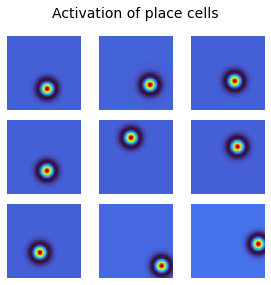

In [11]:
plt.figure(figsize=(4,4))
plt.suptitle("Activation of place cells", fontsize=14)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(pc_outputs[i].reshape(res,res), cmap='turbo')
    plt.axis('off')
plt.tight_layout()

In [12]:
pc_outputs.shape

(512, 3025)

In [13]:
C_ = pc_outputs.T @ pc_outputs
Csquare = C_.reshape(res,res,res,res)

Cmean = np.zeros([res,res])
for i in range(res):
    for j in range(res):
        Cmean += np.roll(np.roll(Csquare[i,j], -i, axis=0), -j, axis=1)

C = np.roll(np.roll(Cmean, res//2, axis=0), res//2, axis=1)

In [14]:
C.min()

2.226757921743768

resは空間を分割するサイズ $n_x$

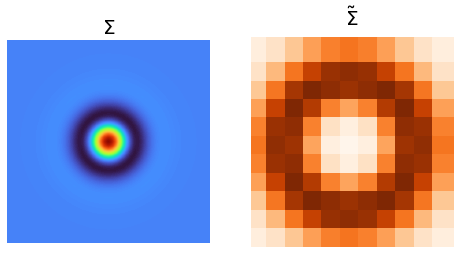

In [15]:
# Fourier transform
Ctilde = np.fft.fft2(C)
Ctilde[0,0] = 0

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(C, cmap='turbo', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs], s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

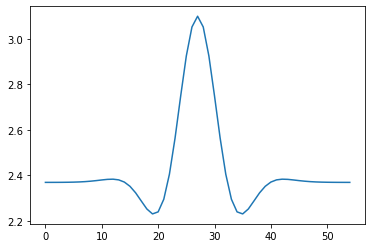

In [16]:
plt.plot(C[res//2])

In [17]:
def convolve_with_C(g, Ctilde):
    '''
    Convolves the input g with the kernel C
    '''
    gtilde = np.fft.fft2(g, [res, res])
    gconv = np.real(np.fft.ifft2(gtilde*Ctilde))
    gconv = np.roll(np.roll(gconv, res//2+1, axis=1), res//2+1, axis=2)
    
    return gconv

In [18]:
# Symmetry preserving nonlinearity (tanh)
Ng = 32
T = 1000
lr = 1e-4
G = np.random.randn(Ng,res,res) * 1e-8

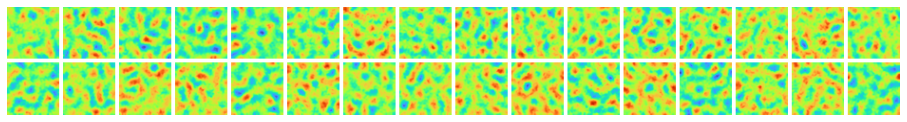

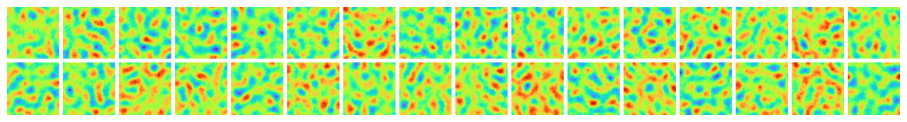

In [19]:
for i in range(T):
    G +=lr*(-G + convolve_with_C(G, Ctilde))
    #G +=lr*(-G + (G.reshape(Ng, -1) @ Sigma).reshape(Ng, res, res))
    G = np.tanh(G)
    
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(G, Ng)
        #plt.imshow(G[0], cmap="turbo")
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')

In [20]:
# Symmetry-breaking nonlinearity (relu)
def relu(x):
    return np.maximum(x,0)

Ng = 32
T = 1000
lr = 5e-3
G = np.random.randn(Ng,res,res) * 1e-8

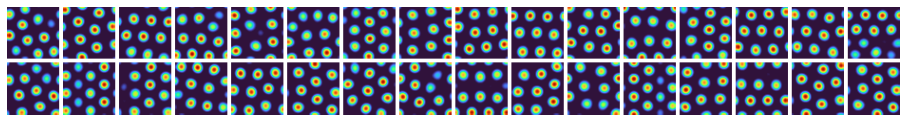

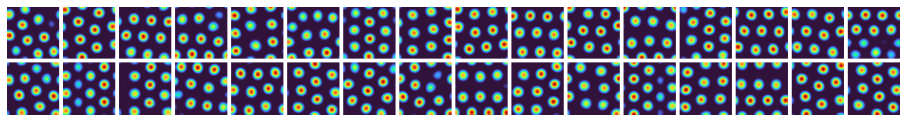

In [21]:
for i in range(T):
    #G +=lr*(-G + (G.reshape(Ng, -1) @ Sigma).reshape(Ng, res, res))
    G +=lr*(-G + convolve_with_C(G, Ctilde))
    G = relu(G)
    
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(G, Ng)
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')

# Multi-grid dynamics

To simulate the multiple grid cell Lagrangian (eq. 11) we include a term which orthogonalizes $G$ using a Gram-Schmidt-like procedure similar to Sanger's multiple PCA algorithm, yielding a hierarchy of grids. Here we use Gaussian place cell tuning curves to demonstrate that the nonlinearity favors hexagonal patterns even when the covariance matrix is not center-surround. However, in this case the first few patterns have square rather than hexagonal symmetry due to discretization of the Fourier lattice as a consequence of finite box size.

複数のグリッドセルラグランジアン（式11）をシミュレートするために、Sangerの多重PCAアルゴリズムに似たグラムシュミット的な手順を用いて$G$を直交化する項を含み、グリッドの階層をもたらす。ここでは、ガウシアンプレイスセル調整曲線を用いて、共分散行列が中心-周囲でない場合でも、非線形性が六角形のパターンに有利であることを実証している。しかし、この場合、最初の数パターンは、有限なボックスサイズの結果としてフーリエ格子の離散化により、六角形の対称性ではなく、正方形の対称性を持っています。

In [29]:
pos_range_min=-1.1
pos_range_max=1.1
grid_x, grid_y = np.meshgrid(
                    np.linspace(pos_range_min, pos_range_max, res), 
                    np.linspace(pos_range_min, pos_range_max, res)
                )
us = np.stack([grid_x.ravel(), grid_y.ravel()]).T

sigma = 0.12
norm2 = np.linalg.norm(us, ord=2, axis=1) 
#C = np.exp(-(norm2)**2 / (2.0 * sigma**2)) 
g1 = np.exp(-(norm2)**2 / (2.0 * sigma**2)) 
g2 = np.exp(-(norm2)**2 / (2.0 * 2.0 * sigma**2)) 

C = g1/np.sum(g1) - g2/np.sum(g2)
C = (C - C.min()) / (C.max() - C.min()) * 0.1
C = C.reshape([res,res])

In [30]:
C.min()

0.0

In [31]:
# Construct fourier transform for later
Ctilde = np.fft.fft2(C, [res, res])

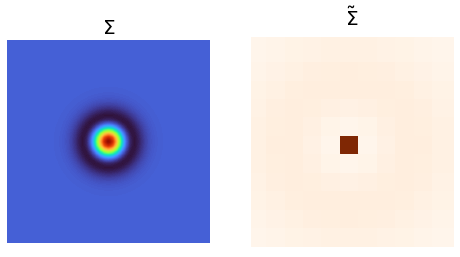

In [32]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(C, cmap='turbo', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs], s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

In [33]:
Ng = 64
r = 30
T = 1000
lr = 8e-3

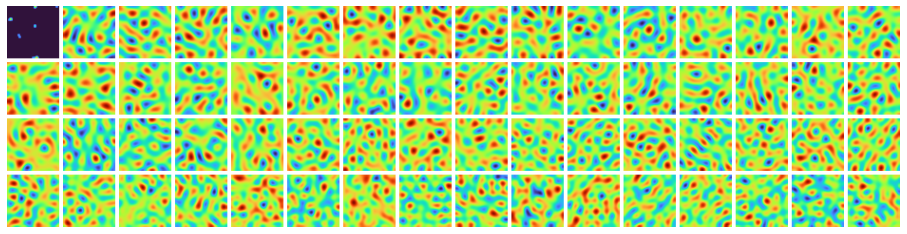

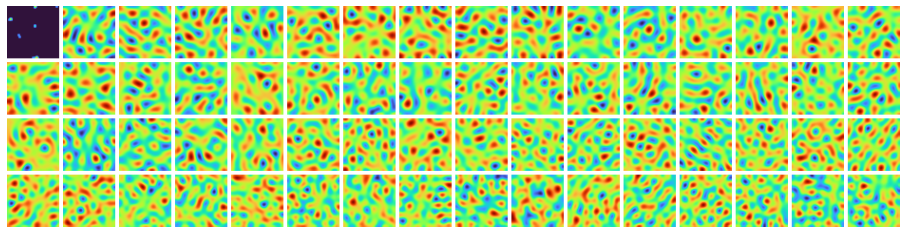

In [34]:
G = np.random.randn(Ng,res,res) * 1e-8

for i in range(T):
    H = convolve_with_C(G, Ctilde)
    Hr = H.reshape([Ng, -1])
    Gr = G.reshape([Ng, -1])
    oja = (Gr.T @ np.tril(Gr @ Hr.T)).T.reshape([Ng,res,res])

    G += lr * (H - oja + np.tanh(G))
    
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(np.flip(G), Ng)
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')

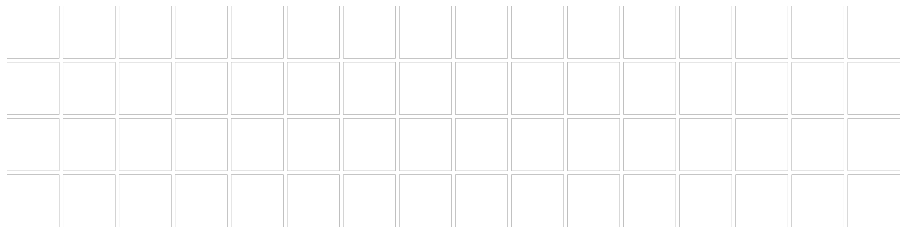

KeyboardInterrupt: 

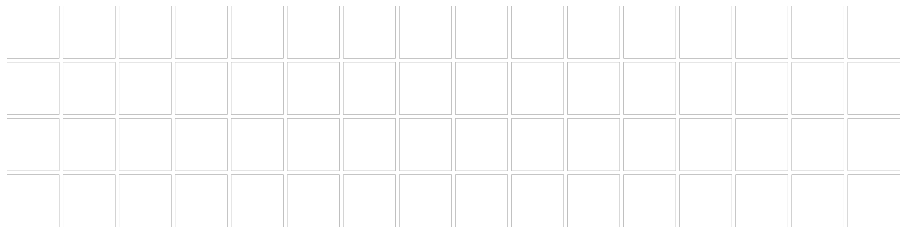

In [35]:
G = np.random.randn(Ng,res,res) * 1e-6

for i in range(T):
    H = convolve_with_C(G, Ctilde)
    Hr = H.reshape([Ng, -1])
    Gr = G.reshape([Ng, -1])
    oja = (Gr.T @ np.tril(Gr @ Hr.T)).T.reshape([Ng,res,res])

    G += lr * (H - oja + r*relu(G))
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(np.flip(G), Ng)
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')